# TP2: Regression Analysis - **2025/2026**
**Student Name:** Atef BOUZID  
**Course:** Practical Introduction to Machine Learning  

## Introduction
This notebook contains solutions to TP2 on Regression Analysis, covering:
- Least Squares regression
- Ridge regression with regularization
- Lasso regression for variable selection
- Non-linear regression methods (Random Forest, SVR, MLP)
- Performance comparison and model evaluation
- Medical applications of brain-computer interfaces


In [40]:
import numpy as np
import pylab as pl
import scipy as sp
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# 1. Load Data

In [2]:
data = np.load('ECoG.npz')
Xall = data['Xall']
Yall = data['Yall']
Fe=data['Fe']

# 2. Data visualization and pre-processing

In [3]:
print(Xall.shape)
print(Yall.shape)
print(Fe.shape)

(3327, 64)
(3327, 1)
(1, 1)


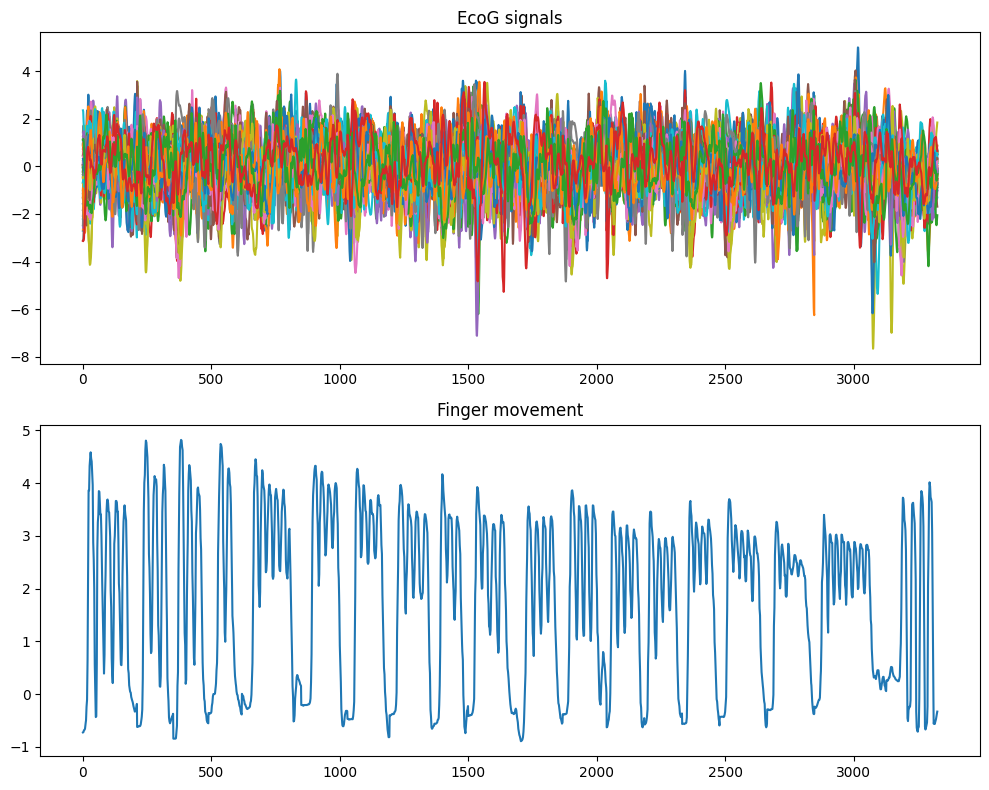

In [4]:
pl.figure(figsize=(10, 8))
pl.subplot(2,1,1)
pl.plot(Xall)
pl.title('EcoG signals')
pl.subplot(2,1,2)
pl.plot(Yall)
pl.title('Finger movement')
pl.tight_layout()
pl.show()


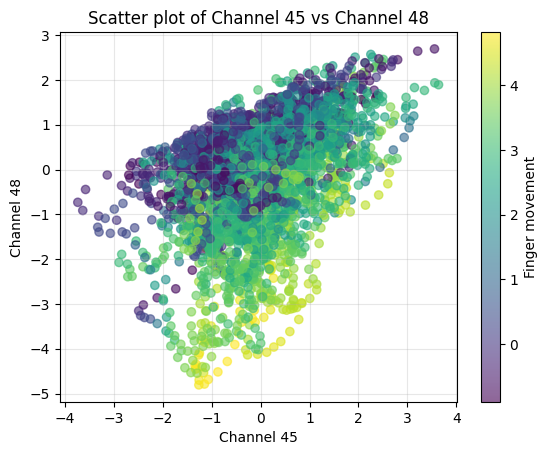

In [5]:
pl.scatter(Xall[:, 45], Xall[:, 48], c=Yall, alpha=0.6)
pl.colorbar(label='Finger movement')
pl.xlabel('Channel 45')
pl.ylabel('Channel 48')
pl.title('Scatter plot of Channel 45 vs Channel 48')
pl.grid(True, alpha=0.3)
pl.show()

In [6]:
n=1000

# training set
x_train = Xall[:n,:]
y_train = Yall[:n]

# testing set
x_test = Xall[n:,:]
y_test = Yall[n:]

# 3. Least Squares regression (LS)

In [7]:
X_tilde = np.concatenate([np.ones((x_train.shape[0], 1)), x_train], axis=1)
print(f"Original x_train shape: {x_train.shape}")
print(f"X_tilde shape: {X_tilde.shape}")



Original x_train shape: (1000, 64)
X_tilde shape: (1000, 65)


In [8]:
W = np.linalg.solve(X_tilde.T @ X_tilde, X_tilde.T @ y_train)

# bias and weight vector
b = W[0] 
w = W[1:] 

print(f"Bias (b): {b}")
print(f"Weight vector (w) shape: {w.shape}")

Bias (b): [1.90081255]
Weight vector (w) shape: (64, 1)


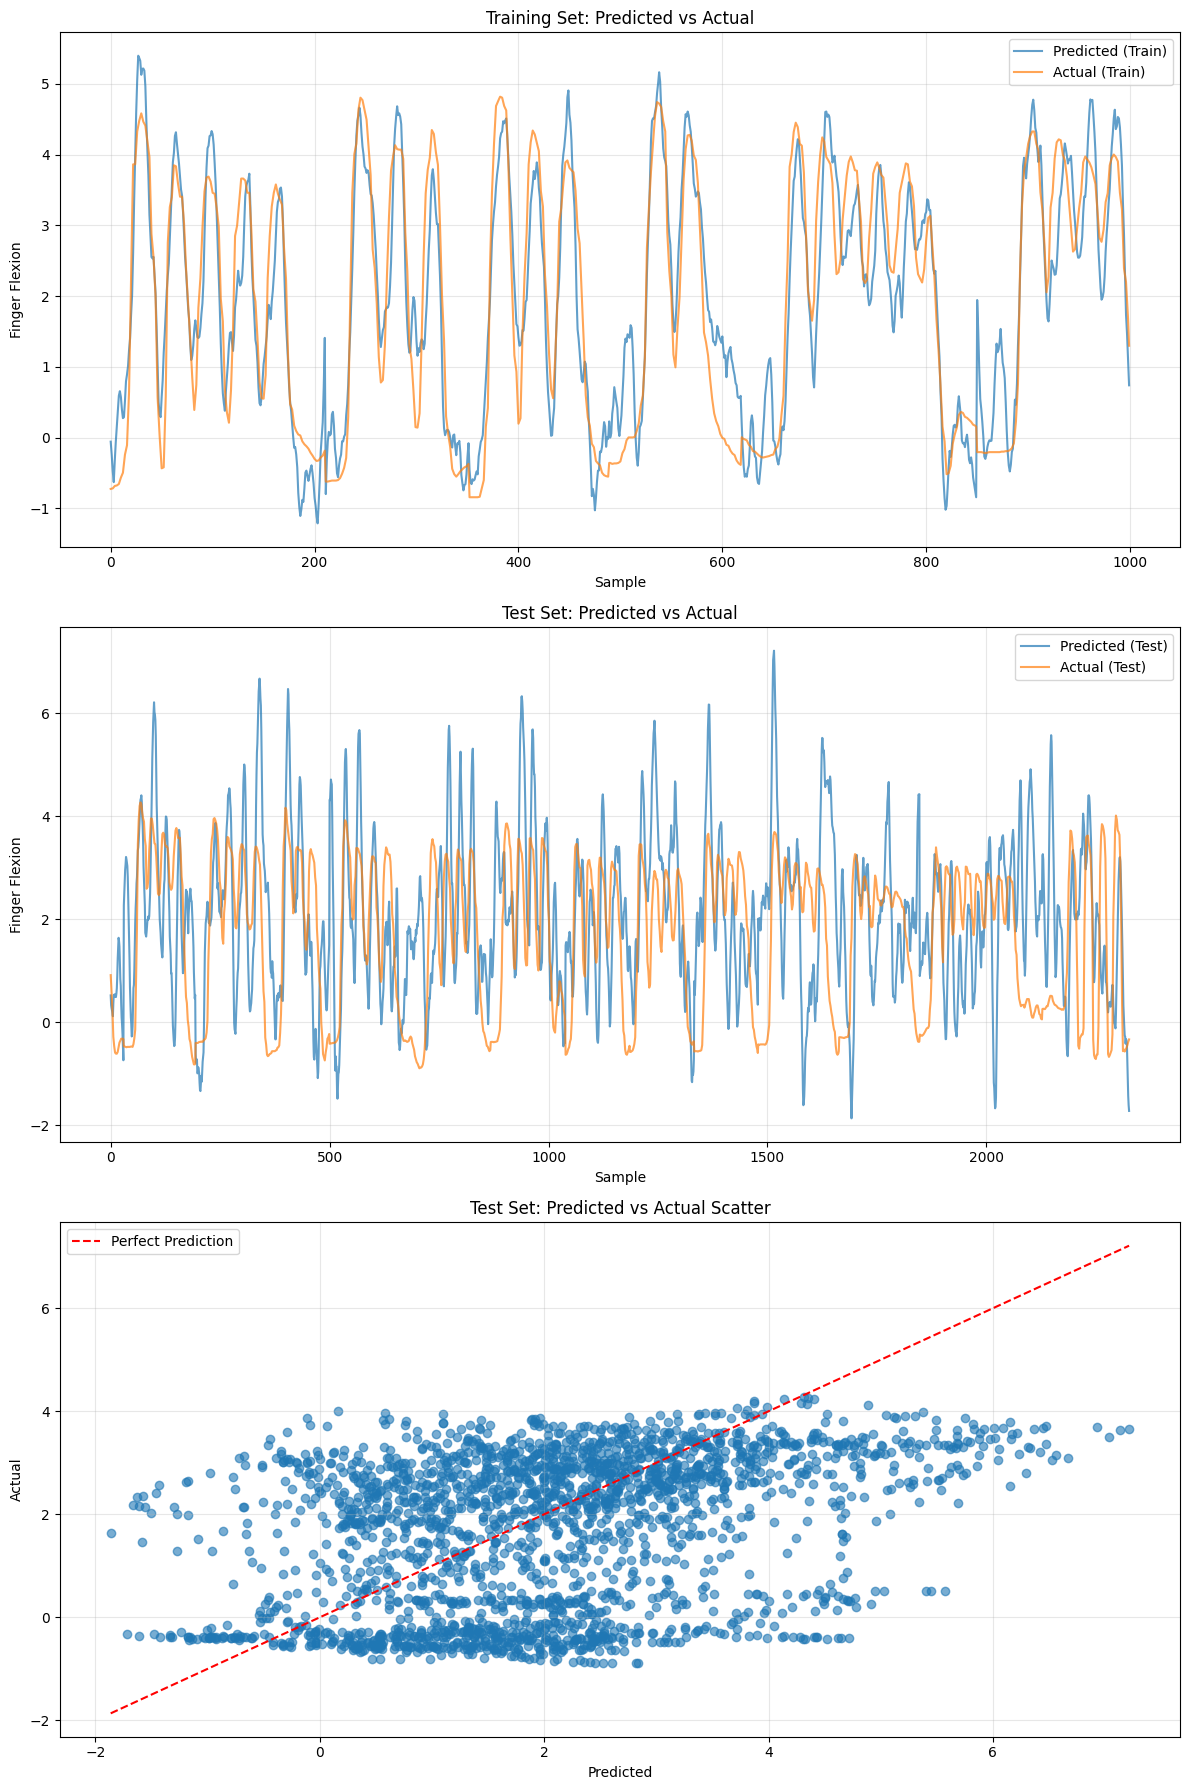

In [9]:
# Predict on training set
pred_train = x_train @ w + b

# Predict on test set
pred_test = x_test @ w + b


y_pred_train_ls = pred_train # we will need this two variables later
y_pred_ls = pred_test

# Plot predictions vs actual values
pl.figure(figsize=(12, 18))

# Training set predictions
pl.subplot(3, 1, 1)
pl.plot(pred_train, label='Predicted (Train)', alpha=0.7)
pl.plot(y_train, label='Actual (Train)', alpha=0.7)
pl.xlabel('Sample')
pl.ylabel('Finger Flexion')
pl.title('Training Set: Predicted vs Actual')
pl.legend()
pl.grid(True, alpha=0.3)

# Test set predictions
pl.subplot(3, 1, 2)
pl.plot(pred_test, label='Predicted (Test)', alpha=0.7)
pl.plot(y_test, label='Actual (Test)', alpha=0.7)
pl.xlabel('Sample')
pl.ylabel('Finger Flexion')
pl.title('Test Set: Predicted vs Actual')
pl.legend()
pl.grid(True, alpha=0.3)

# Scatter plot for test set
pl.subplot(3, 1, 3)
pl.scatter(pred_test, y_test, alpha=0.6)
pl.plot([min(pred_test), max(pred_test)], [min(pred_test), max(pred_test)], 'r--', label='Perfect Prediction')
pl.xlabel('Predicted')
pl.ylabel('Actual')
pl.title('Test Set: Predicted vs Actual Scatter')
pl.legend()
pl.grid(True, alpha=0.3)

pl.tight_layout()
pl.show()


the prediction result on the train looks good but when but the performance are bad and poor on the test it looks like an overfitting problem.

In [10]:
train_mse = np.mean((pred_train - y_train)**2)
test_mse = np.mean((pred_test - y_test)**2)
train_r2 = 1 - np.sum((y_train - pred_train)**2) / np.sum((y_train - np.mean(y_train))**2)
test_r2 = 1 - np.sum((y_test - pred_test)**2) / np.sum((y_test - np.mean(y_test))**2)

print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Training MSE: 0.5041
Test MSE: 3.0455
Training R²: 0.8395
Test R²: -0.4282


The model shows clear signs of overfitting:
- Training performance is excellent (R² > 0.8, MSE ≈ 0.5)
- Test performance is significantly worse (low R², high MSE)

This indicates the model has memorized the training data but fails to generalize to new data.

In [11]:
w.flatten()

array([-0.09150694,  0.10861623, -0.07305774, -0.27938349,  0.25112061,
        0.41213833,  0.14387528, -0.19811799,  0.40869961,  0.7059866 ,
       -0.4557358 ,  0.02140866,  0.35947183, -0.01042572, -0.17655887,
       -0.03377368, -0.11345198, -0.72143135, -0.5950915 ,  0.23329595,
       -0.65132811, -0.33317441,  0.28861537,  0.24498034,  0.22062027,
        0.19042788,  0.20709995,  0.3273775 , -0.65410592,  0.11997444,
       -0.07491945,  0.10667581,  0.11003235, -0.42910159, -0.22329342,
       -0.00381723, -0.06046664, -0.1595164 , -0.48519392,  0.15019433,
        0.25855769, -0.09242374,  0.76314124, -0.0834797 ,  0.04489988,
       -0.16816255,  0.04845934,  0.0256902 , -1.03905805,  0.16060454,
       -0.19110549,  0.16557271,  0.08064689,  0.27554638, -0.01162067,
       -0.00740264,  0.33850545,  0.22409642, -0.2196636 , -0.26866884,
       -0.16469195, -0.23638421,  0.04244268,  0.5694358 ])

In [12]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)

# check if coefficients match our manually computed ones
print("Coefficients comparison:")
print(f"sklearn coefficients: {lr.coef_[:10]}")
print(f"Manual coefficients: {w.flatten()[:10]}")
print(f"\n==> Coefficients are equal: {np.allclose(lr.coef_.flatten()[:10], w.flatten()[:10])}")

print("\nIntercept comparison:")
print(f"sklearn intercept: {lr.intercept_}")
print(f"Manual intercept: {b}")
print(f"\n==> Intercepts are equal: {np.allclose(lr.intercept_, b)}")

Coefficients comparison:
sklearn coefficients: [[-0.09150694  0.10861623 -0.07305774 -0.27938349  0.25112061  0.41213833
   0.14387528 -0.19811799  0.40869961  0.7059866  -0.4557358   0.02140866
   0.35947183 -0.01042572 -0.17655887 -0.03377368 -0.11345198 -0.72143135
  -0.5950915   0.23329595 -0.65132811 -0.33317441  0.28861537  0.24498034
   0.22062027  0.19042788  0.20709995  0.3273775  -0.65410592  0.11997444
  -0.07491945  0.10667581  0.11003235 -0.42910159 -0.22329342 -0.00381723
  -0.06046664 -0.1595164  -0.48519392  0.15019433  0.25855769 -0.09242374
   0.76314124 -0.0834797   0.04489988 -0.16816255  0.04845934  0.0256902
  -1.03905805  0.16060454 -0.19110549  0.16557271  0.08064689  0.27554638
  -0.01162067 -0.00740264  0.33850545  0.22409642 -0.2196636  -0.26866884
  -0.16469195 -0.23638421  0.04244268  0.5694358 ]]
Manual coefficients: [-0.09150694  0.10861623 -0.07305774 -0.27938349  0.25112061  0.41213833
  0.14387528 -0.19811799  0.40869961  0.7059866 ]

==> Coefficients 

The estimated coefficients are the same as those estimated above.

# 4. Ridge regression

In [13]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
ridge = Ridge(alpha=1)
ridge.fit(x_train, y_train)

# predict on training and test sets
pred_train_ridge = ridge.predict(x_train)
pred_test_ridge = ridge.predict(x_test)

# training performance
mse_train_ridge = mean_squared_error(y_train, pred_train_ridge)
r2_train_ridge = r2_score(y_train, pred_train_ridge)

# test performance
mse_test_ridge = mean_squared_error(y_test, pred_test_ridge)
r2_test_ridge = r2_score(y_test, pred_test_ridge)

print("Ridge Regression Performance (λ = 1):")
print(f"Training - MSE: {mse_train_ridge:.4f}, R²: {r2_train_ridge:.4f}")
print(f"Test - MSE: {mse_test_ridge:.4f}, R²: {r2_test_ridge:.4f}")

Ridge Regression Performance (λ = 1):
Training - MSE: 0.5042, R²: 0.8395
Test - MSE: 3.0038, R²: -0.4086


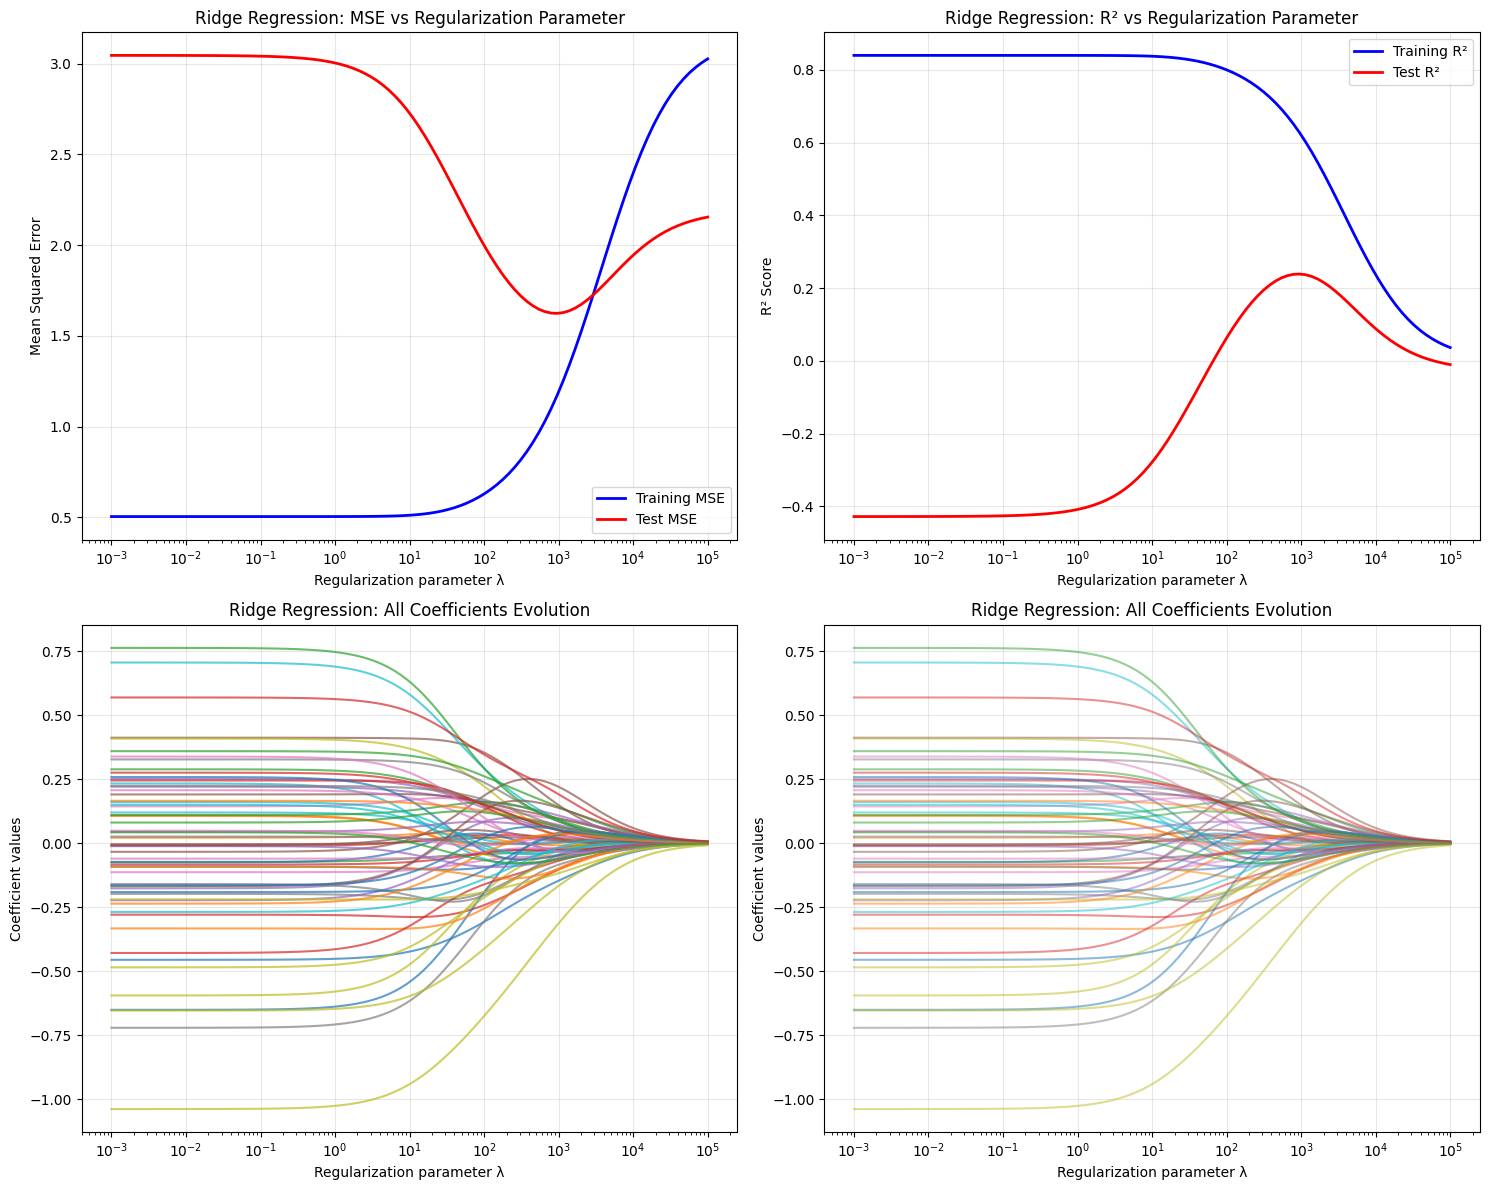

In [15]:
lambdas = np.logspace(-3, 5, 100)

mse_train_ridge_values = []
mse_test_ridge_values = []
r2_train_ridge_values = []
r2_test_ridge_values = []
coefficients_ridge = []

for alpha in lambdas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(x_train, y_train)
    
    # Make predictions
    pred_train = ridge_model.predict(x_train)
    pred_test = ridge_model.predict(x_test)
    
    # Calculate MSE and R²
    mse_train = mean_squared_error(y_train, pred_train)
    mse_test = mean_squared_error(y_test, pred_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    
    # Store results
    mse_train_ridge_values.append(mse_train)
    mse_test_ridge_values.append(mse_test)
    r2_train_ridge_values.append(r2_train)
    r2_test_ridge_values.append(r2_test)
    coefficients_ridge.append(ridge_model.coef_)

coefficients_ridge = np.array(coefficients_ridge)

fig, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2, figsize=(15, 12))

# Plot MSE evolution
ax1.semilogx(lambdas, mse_train_ridge_values, 'b-', label='Training MSE', linewidth=2)
ax1.semilogx(lambdas, mse_test_ridge_values, 'r-', label='Test MSE', linewidth=2)
ax1.set_xlabel('Regularization parameter λ')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Ridge Regression: MSE vs Regularization Parameter')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot R² evolution
ax2.semilogx(lambdas, r2_train_ridge_values, 'b-', label='Training R²', linewidth=2)
ax2.semilogx(lambdas, r2_test_ridge_values, 'r-', label='Test R²', linewidth=2)
ax2.set_xlabel('Regularization parameter λ')
ax2.set_ylabel('R² Score')
ax2.set_title('Ridge Regression: R² vs Regularization Parameter')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot all coefficients evolution
for i in range(coefficients_ridge.shape[1]):
    ax3.semilogx(lambdas, coefficients_ridge[:, i], label=f'Coef {i+1}', alpha=0.7)
ax3.set_xlabel('Regularization parameter λ')
ax3.set_ylabel('Coefficient values')
ax3.set_title('Ridge Regression: All Coefficients Evolution')
ax3.grid(True, alpha=0.3)

for i in range(coefficients_ridge.shape[1]):
    ax4.semilogx(lambdas, coefficients_ridge[:, i], alpha=0.5)
ax4.set_xlabel('Regularization parameter λ')
ax4.set_ylabel('Coefficient values')
ax4.set_title('Ridge Regression: All Coefficients Evolution')
ax4.grid(True, alpha=0.3)

pl.tight_layout()
pl.show()


In [16]:
# optimal lambda based on test MSE
optimal_idx = np.argmin(mse_test_ridge_values)
optimal_lambda = lambdas[optimal_idx]
optimal_mse_test = mse_test_ridge_values[optimal_idx]
optimal_r2_test = r2_test_ridge_values[optimal_idx]

print(f"\nOptimal λ: {optimal_lambda:.4f}")
print(f"Minimum Test MSE: {optimal_mse_test:.4f}")
print(f"Corresponding Test R²: {optimal_r2_test:.4f}")


Optimal λ: 954.5485
Minimum Test MSE: 1.6239
Corresponding Test R²: 0.2385


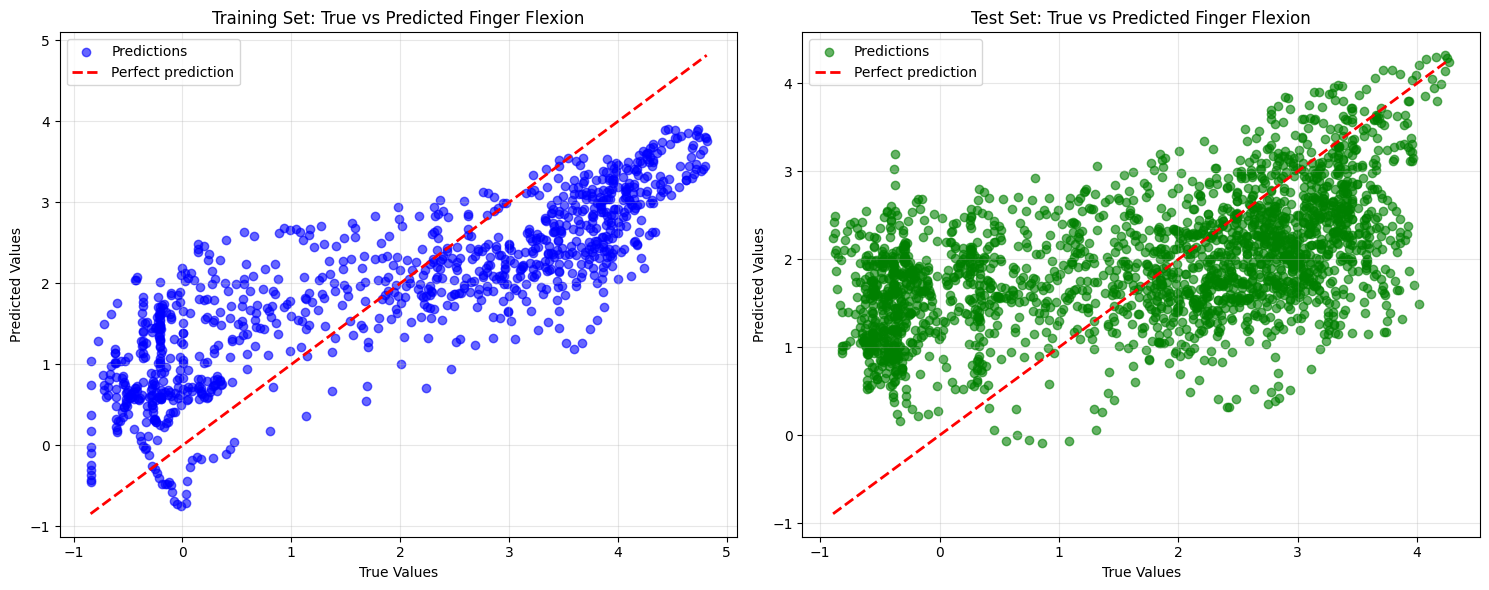

In [17]:
ridge_optimal = Ridge(alpha=optimal_lambda)
ridge_optimal.fit(x_train, y_train)

# preds
y_train_pred = ridge_optimal.predict(x_train)
y_test_pred = ridge_optimal.predict(x_test)

pl.figure(figsize=(15, 6))

# train
pl.subplot(1, 2, 1)
pl.scatter(y_train, y_train_pred, alpha=0.6, color='blue', label='Predictions')
pl.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect prediction')
pl.xlabel('True Values')
pl.ylabel('Predicted Values')
pl.title('Training Set: True vs Predicted Finger Flexion')
pl.legend()
pl.grid(True, alpha=0.3)

# on test
pl.subplot(1, 2, 2)
pl.scatter(y_test, y_test_pred, alpha=0.6, color='green', label='Predictions')
pl.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
pl.xlabel('True Values')
pl.ylabel('Predicted Values')
pl.title('Test Set: True vs Predicted Finger Flexion')
pl.legend()
pl.grid(True, alpha=0.3)

pl.tight_layout()
pl.show()

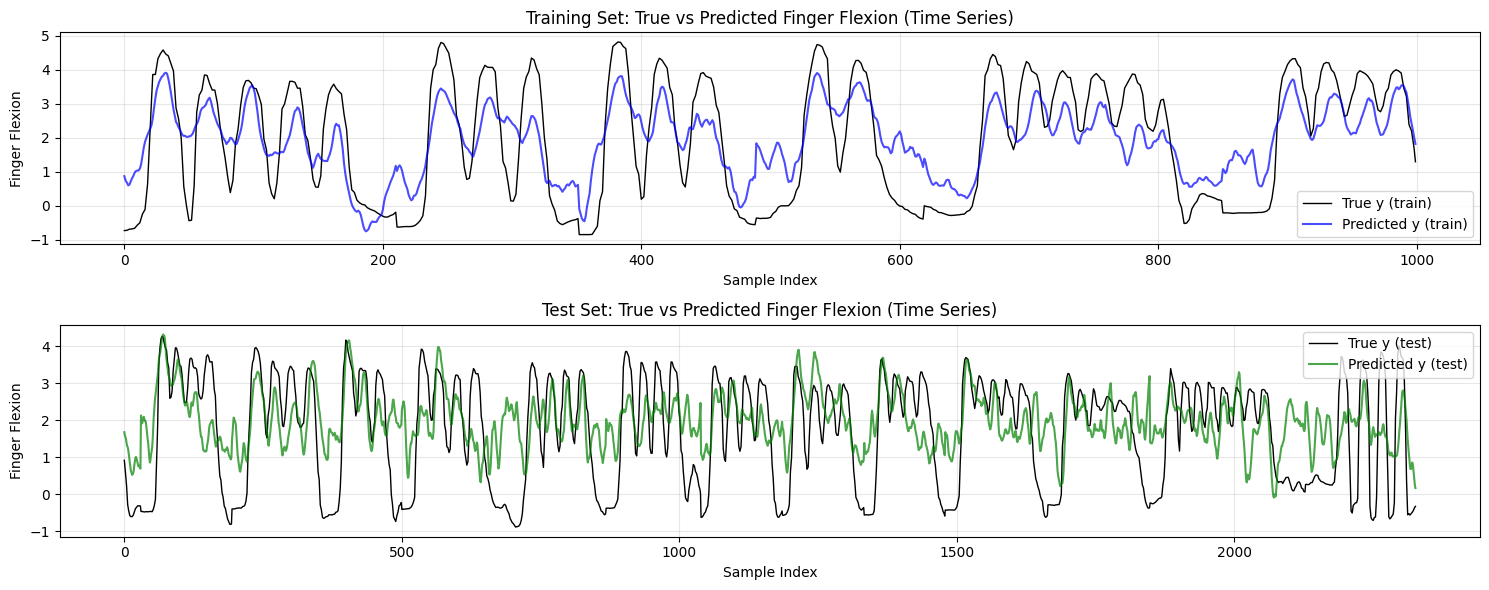

In [18]:
ridge_optimal = Ridge(alpha=optimal_lambda)
ridge_optimal.fit(x_train, y_train)

# preds
y_train_pred = ridge_optimal.predict(x_train)
y_test_pred = ridge_optimal.predict(x_test)

pl.figure(figsize=(15, 6))

# train
pl.subplot(2, 1, 1)
pl.plot(y_train, label='True y (train)', color='black', linewidth=1)
pl.plot(y_train_pred, label='Predicted y (train)', color='blue', alpha=0.7)
pl.xlabel('Sample Index')
pl.ylabel('Finger Flexion')
pl.title('Training Set: True vs Predicted Finger Flexion (Time Series)')
pl.legend()
pl.grid(True, alpha=0.3)

# test
pl.subplot(2, 1, 2)
pl.plot(y_test, label='True y (test)', color='black', linewidth=1)
pl.plot(y_test_pred, label='Predicted y (test)', color='green', alpha=0.7)
pl.xlabel('Sample Index')
pl.ylabel('Finger Flexion')
pl.title('Test Set: True vs Predicted Finger Flexion (Time Series)')
pl.legend()
pl.grid(True, alpha=0.3)

pl.tight_layout()
pl.show()

> When we used lambda = 1, we observed overfitting: the model performed well on the training data but poorly on the test data. However, after selecting the optimal lambda (around 954), the gap between the training and test errors became much smaller. The results are significantly improved, the model follows the trend of the data and predicts reasonable values on the test set. Therefore, the prediction on the test data is good, as the model generalizes well and does not overfit.

In [19]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

y_train_pred_ridge = y_train_pred
y_pred_ridge = y_test_pred

print(f"Prediction Performance with Optimal λ = {optimal_lambda:.4f}:")
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Prediction Performance with Optimal λ = 954.5485:
Training MSE: 1.1719
Test MSE: 1.6239
Training R²: 0.6268
Test R²: 0.2385



> **LS (Least Squares) Results:**
   - Training MSE: 0.5041
   - Test MSE: 3.0455
   - Training R²: 0.8395
   - Test R²: -0.4282

> **Ridge Regression Results:**
   - Training MSE: 1.1719
   - Test MSE: 1.6239
   - Training R²: 0.6268
   - Test R²: 0.2385


>  The LS estimator achieves a lower training error and higher training R², indicating it fits the training data very well. However, its test error is much higher and the test R² is negative, which means it generalizes poorly and suffers from overfitting. **In contrast**, Ridge regression has a higher training error (and lower training R²), but its test error is significantly lower and the test R² is positive. This shows that Ridge regression, by introducing regularization, reduces overfitting and improves generalization to unseen data. The trade-off is a slightly worse fit on the training set, but much better performance on the test set.

In [20]:
w_ls = w.flatten()
w_ridge = ridge_optimal.coef_
print("W (for LS) : ",w_ls)
print("\nW (for Ridge) : ",w_ridge)

W (for LS) :  [-0.09150694  0.10861623 -0.07305774 -0.27938349  0.25112061  0.41213833
  0.14387528 -0.19811799  0.40869961  0.7059866  -0.4557358   0.02140866
  0.35947183 -0.01042572 -0.17655887 -0.03377368 -0.11345198 -0.72143135
 -0.5950915   0.23329595 -0.65132811 -0.33317441  0.28861537  0.24498034
  0.22062027  0.19042788  0.20709995  0.3273775  -0.65410592  0.11997444
 -0.07491945  0.10667581  0.11003235 -0.42910159 -0.22329342 -0.00381723
 -0.06046664 -0.1595164  -0.48519392  0.15019433  0.25855769 -0.09242374
  0.76314124 -0.0834797   0.04489988 -0.16816255  0.04845934  0.0256902
 -1.03905805  0.16060454 -0.19110549  0.16557271  0.08064689  0.27554638
 -0.01162067 -0.00740264  0.33850545  0.22409642 -0.2196636  -0.26866884
 -0.16469195 -0.23638421  0.04244268  0.5694358 ]

W (for Ridge) :  [-0.02640053 -0.05029049 -0.02029002 -0.10571625  0.05316002  0.15274951
  0.09436534 -0.05960404  0.02433899  0.09325278 -0.14928329 -0.00844216
  0.1438586   0.0162682   0.07282022  0.223

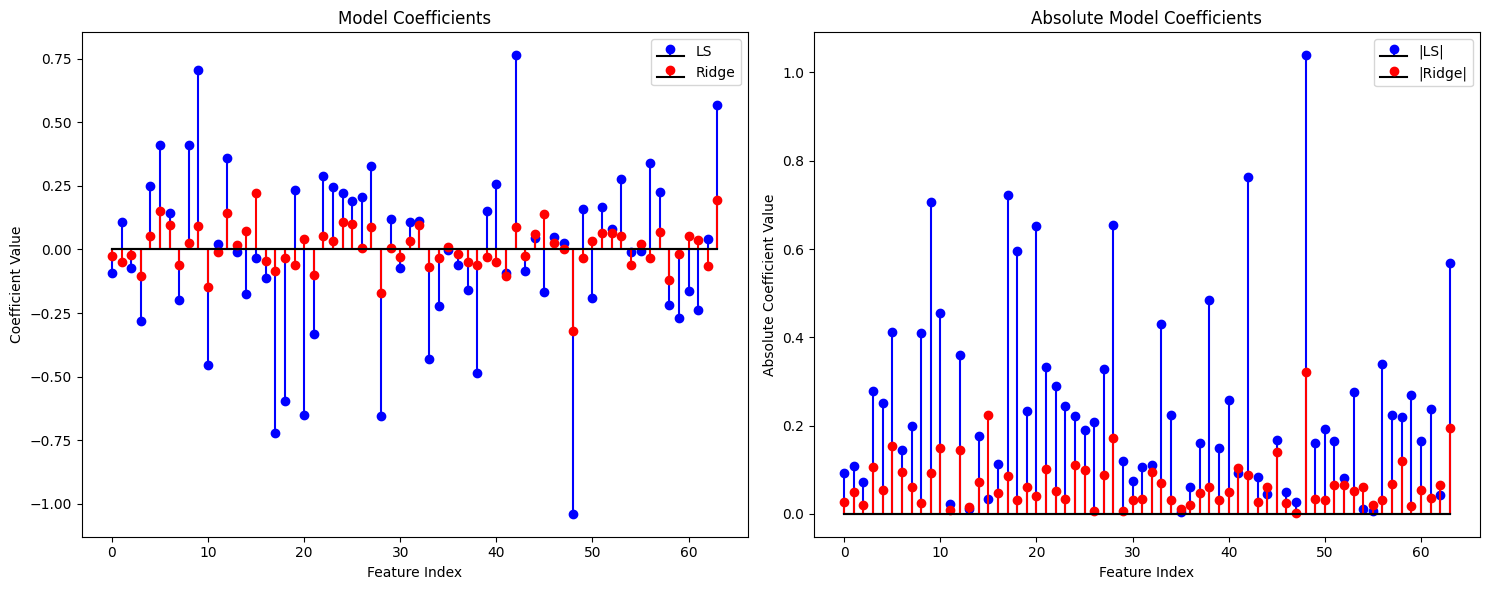

In [21]:
# plot coefficients
pl.figure(figsize=(15, 6))

pl.subplot(1, 2, 1)
pl.stem(w_ls, linefmt='b-', markerfmt='bo', basefmt='k-', label='LS')
pl.stem(w_ridge, linefmt='r-', markerfmt='ro', basefmt='k-', label='Ridge')
pl.title('Model Coefficients')
pl.xlabel('Feature Index')
pl.ylabel('Coefficient Value')
pl.legend()

pl.subplot(1, 2, 2)
pl.stem(np.abs(w_ls), linefmt='b-', markerfmt='bo', basefmt='k-', label='|LS|')
pl.stem(np.abs(w_ridge), linefmt='r-', markerfmt='ro', basefmt='k-', label='|Ridge|')
pl.title('Absolute Model Coefficients')
pl.xlabel('Feature Index')
pl.ylabel('Absolute Coefficient Value')
pl.legend()

pl.tight_layout()
pl.show()

# 5. Variable selection with the Lasso

In [22]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
lasso_default = Lasso()
lasso_default.fit(x_train, y_train)
y_train_pred_lasso = lasso_default.predict(x_train)
y_test_pred_lasso = lasso_default.predict(x_test)


Lasso (default alpha) Training MSE: 3.1405971577280063
Lasso (default alpha) Test MSE: 2.190675841640482
Lasso (default alpha) Training R²: 0.0
Lasso (default alpha) Test R²: -0.02729265197579034


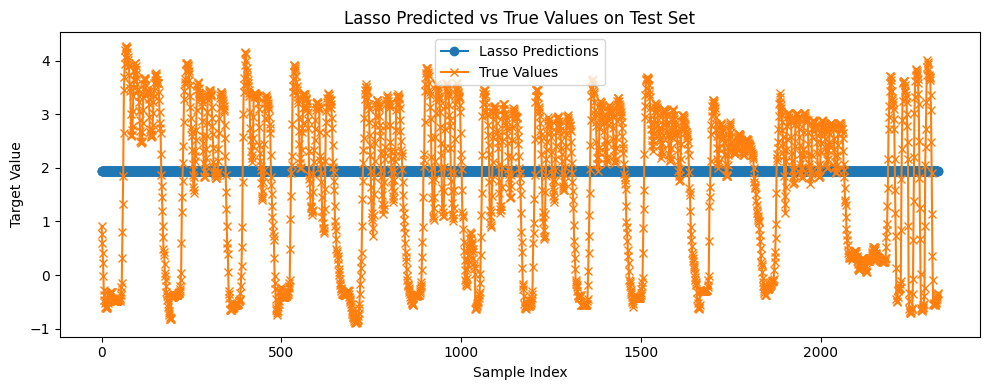

In [24]:
mse_train_lasso = mean_squared_error(y_train, y_train_pred_lasso)
mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

print("Lasso (default alpha) Training MSE:", mse_train_lasso)
print("Lasso (default alpha) Test MSE:", mse_test_lasso)
print("Lasso (default alpha) Training R²:", r2_train_lasso)
print("Lasso (default alpha) Test R²:", r2_test_lasso)

pl.figure(figsize=(10,4))
pl.plot(y_test_pred_lasso, label='Lasso Predictions', marker='o')
pl.plot(y_test.values if hasattr(y_test, 'values') else y_test, label='True Values', marker='x')
pl.title('Lasso Predicted vs True Values on Test Set')
pl.xlabel('Sample Index')
pl.ylabel('Target Value')
pl.legend()
pl.tight_layout()
pl.show()

In [25]:
lasso_default.coef_

array([ 0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0.,  0.,
       -0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,  0., -0.,  0.,  0.,
        0.,  0., -0.,  0., -0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,
        0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0.,  0.])

>    - The Lasso model with default alpha gives a Training R² of 0.0 and a Test R² of about -0.03, which means it is not capturing any variance in the data (essentially predicting the mean).
>    - All the Lasso coefficients are zero (or very close to zero), indicating that the regularization is too strong and the model is effectively ignoring all features.
>    - This suggests that the default alpha is too high for this dataset, and we need to tune alpha (lambda) to find a value that allows the model to select relevant variables and improve performance.


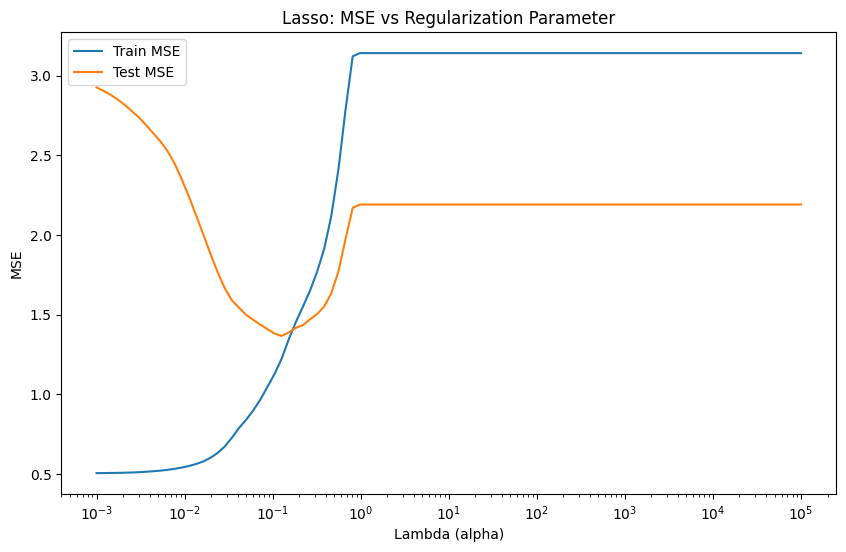

In [26]:
lambdas = np.logspace(-3, 5, 100)
mse_train_lasso_list = []
mse_test_lasso_list = []
lasso_coefs = []

for alpha in lambdas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(x_train, y_train)
    y_train_pred = lasso.predict(x_train)
    y_test_pred = lasso.predict(x_test)
    mse_train_lasso_list.append(mean_squared_error(y_train, y_train_pred))
    mse_test_lasso_list.append(mean_squared_error(y_test, y_test_pred))
    lasso_coefs.append(lasso.coef_)

mse_train_lasso_list = np.array(mse_train_lasso_list)
mse_test_lasso_list = np.array(mse_test_lasso_list)
lasso_coefs = np.array(lasso_coefs)

# Plot evolution of MSE as a function of lambda
pl.figure(figsize=(10,6))
pl.plot(lambdas, mse_train_lasso_list, label='Train MSE')
pl.plot(lambdas, mse_test_lasso_list, label='Test MSE')
pl.xscale('log')
pl.xlabel('Lambda (alpha)')
pl.ylabel('MSE')
pl.title('Lasso: MSE vs Regularization Parameter')
pl.legend()
pl.show()

In [27]:
best_lambda_idx = np.argmin(mse_test_lasso_list)
best_lambda = lambdas[best_lambda_idx]
print("Best lambda (alpha) for Lasso:", best_lambda)

Best lambda (alpha) for Lasso: 0.1261856883066021


In [28]:
# Estimate Lasso with best lambda
lasso_best = Lasso(alpha=best_lambda, max_iter=10000)
lasso_best.fit(x_train, y_train)
y_train_pred_best = lasso_best.predict(x_train)
y_test_pred_best = lasso_best.predict(x_test)
y_pred_lasso= y_test_pred_best # we will use it later

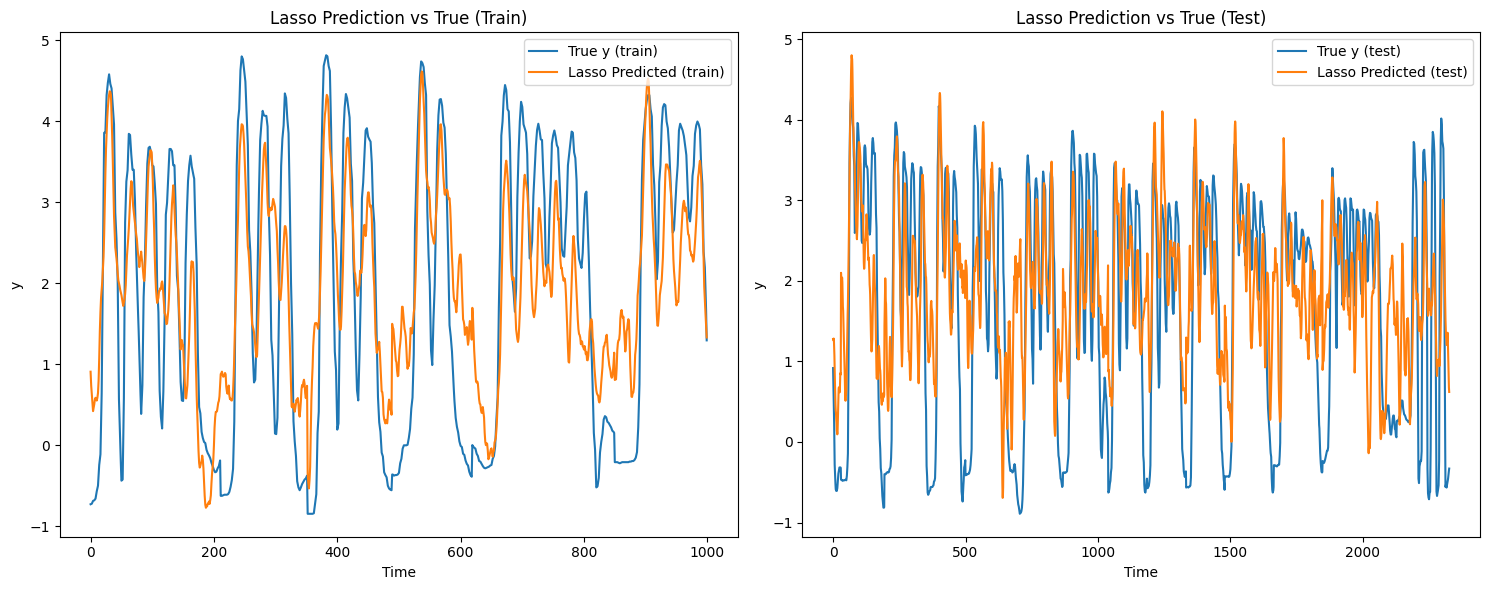

In [29]:
pl.figure(figsize=(15,6))
pl.subplot(1,2,1)
pl.plot(y_train, label='True y (train)')
pl.plot(y_train_pred_best, label='Lasso Predicted (train)')
pl.title('Lasso Prediction vs True (Train)')
pl.xlabel('Time')
pl.ylabel('y')
pl.legend()

pl.subplot(1,2,2)
pl.plot(y_test, label='True y (test)')
pl.plot(y_test_pred_best, label='Lasso Predicted (test)')
pl.title('Lasso Prediction vs True (Test)')
pl.xlabel('Time')
pl.ylabel('y')
pl.legend()
pl.tight_layout()
pl.show()

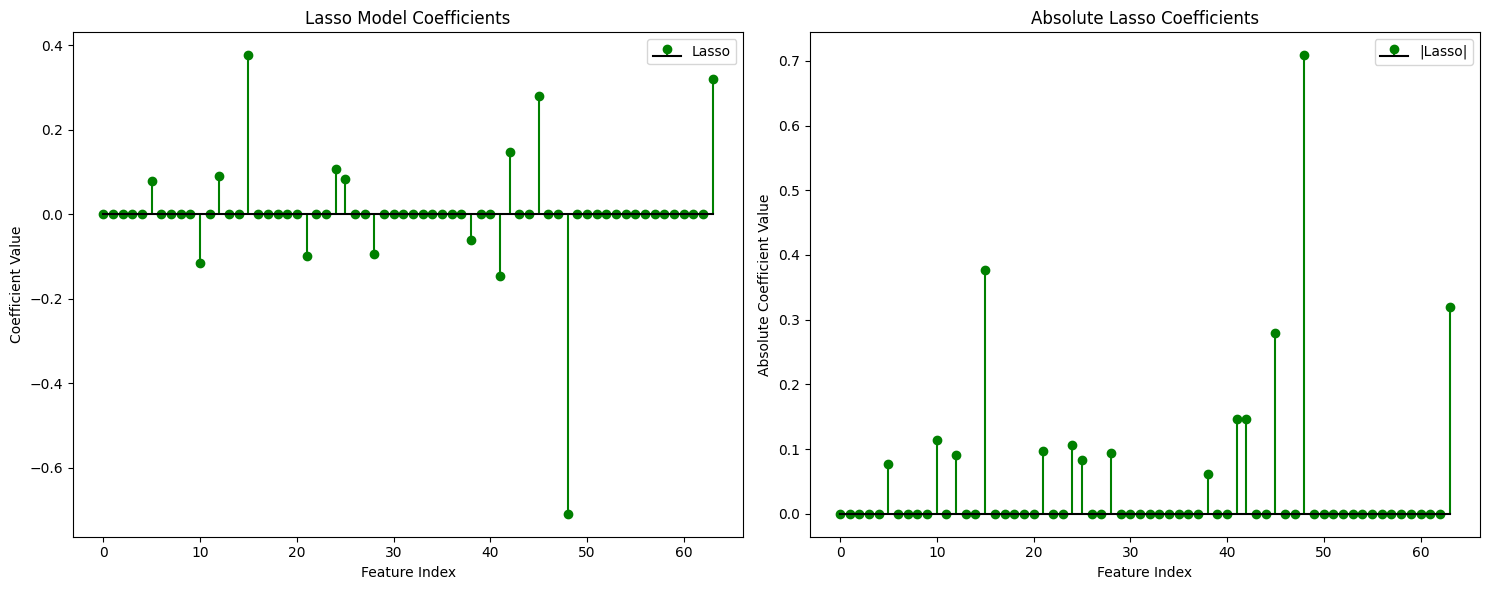

In [30]:
w_lasso = lasso_best.coef_

pl.figure(figsize=(15,6))
pl.subplot(1,2,1)
pl.stem(w_lasso, linefmt='g-', markerfmt='go', basefmt='k-', label='Lasso')
pl.title('Lasso Model Coefficients')
pl.xlabel('Feature Index')
pl.ylabel('Coefficient Value')
pl.legend()

pl.subplot(1,2,2)
pl.stem(np.abs(w_lasso), linefmt='g-', markerfmt='go', basefmt='k-', label='|Lasso|')
pl.title('Absolute Lasso Coefficients')
pl.xlabel('Feature Index')
pl.ylabel('Absolute Coefficient Value')
pl.legend()
pl.tight_layout()
pl.show()

In [31]:
most_important_idx = np.argsort(np.abs(w_lasso))[-2:][::-1]
print("Indices of two most important variables (by |coef|):", most_important_idx)
print("Values:", w_lasso[most_important_idx])

Indices of two most important variables (by |coef|): [48 15]
Values: [-0.70862161  0.37611771]


In [32]:
n_selected = np.sum(w_lasso != 0)
print("Number of features selected by Lasso (nonzero coefficients):", n_selected)
print("Reduction in number of electrodes/features: {} -> {}".format(len(w_lasso), n_selected))

Number of features selected by Lasso (nonzero coefficients): 14
Reduction in number of electrodes/features: 64 -> 14


# 6. Nonlinear regression

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [34]:
# Fit and evaluate RandomForestRegressor
rf = RandomForestRegressor(random_state=0)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("RandomForestRegressor - MSE: {:.4f}, R2: {:.4f}".format(mse_rf, r2_rf))

# Fit and evaluate SVR
svr = SVR()
svr.fit(x_train, y_train)
y_pred_svr = svr.predict(x_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print("SVR - MSE: {:.4f}, R2: {:.4f}".format(mse_svr, r2_svr))

# Fit and evaluate MLPRegressor
mlp = MLPRegressor(random_state=0, max_iter=1000)
mlp.fit(x_train, y_train)
y_pred_mlp = mlp.predict(x_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
print("MLPRegressor - MSE: {:.4f}, R2: {:.4f}".format(mse_mlp, r2_mlp))

# Compare with LS, Ridge, Lasso
print("\nPreviously computed performances:")
print("LS - MSE: {:.4f}, R2: {:.4f}".format(mean_squared_error(y_test, y_pred_ls), r2_score(y_test, y_pred_ls)))
print("Ridge - MSE: {:.4f}, R2: {:.4f}".format(mean_squared_error(y_test, y_pred_ridge), r2_score(y_test, y_pred_ridge)))
print("Lasso - MSE: {:.4f}, R2: {:.4f}".format(mean_squared_error(y_test, y_pred_lasso), r2_score(y_test, y_pred_lasso)))


RandomForestRegressor - MSE: 1.6428, R2: 0.2296
SVR - MSE: 1.5152, R2: 0.2895
MLPRegressor - MSE: 2.4920, R2: -0.1686

Previously computed performances:
LS - MSE: 3.0455, R2: -0.4282
Ridge - MSE: 1.6239, R2: 0.2385
Lasso - MSE: 1.3660, R2: 0.3595


In [35]:
# Parameter validation for RandomForestRegressor
rf_n_estimators = [10, 50, 100, 200]
rf_max_depth = [None, 5, 10, 20]
best_mse_rf = float('inf')
best_params_rf = None
for n in rf_n_estimators:
    for d in rf_max_depth:
        rf_tmp = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=0)
        rf_tmp.fit(x_train, y_train)
        y_pred_tmp = rf_tmp.predict(x_test)
        mse_tmp = mean_squared_error(y_test, y_pred_tmp)
        if mse_tmp < best_mse_rf:
            best_mse_rf = mse_tmp
            best_params_rf = (n, d)
print("\nBest RandomForestRegressor params: n_estimators={}, max_depth={}, MSE={:.4f}".format(
    best_params_rf[0], best_params_rf[1], best_mse_rf))


Best RandomForestRegressor params: n_estimators=100, max_depth=20, MSE=1.6419


In [36]:
# Parameter validation for SVR
svr_C = [0.1, 1, 10]
svr_gamma = ['scale', 0.01, 0.1, 1]
best_mse_svr = float('inf')
best_params_svr = None
for C in svr_C:
    for gamma in svr_gamma:
        svr_tmp = SVR(C=C, gamma=gamma)
        svr_tmp.fit(x_train, y_train)
        y_pred_tmp = svr_tmp.predict(x_test)
        mse_tmp = mean_squared_error(y_test, y_pred_tmp)
        if mse_tmp < best_mse_svr:
            best_mse_svr = mse_tmp
            best_params_svr = (C, gamma)
print("Best SVR params: C={}, gamma={}, MSE={:.4f}".format(
    best_params_svr[0], best_params_svr[1], best_mse_svr))

Best SVR params: C=1, gamma=scale, MSE=1.5152


In [37]:
# Parameter validation for MLPRegressor
mlp_hidden = [(50,), (100,), (100, 50)]
mlp_alpha = [0.0001, 0.001, 0.01]
best_mse_mlp = float('inf')
best_params_mlp = None
for h in mlp_hidden:
    for a in mlp_alpha:
        mlp_tmp = MLPRegressor(hidden_layer_sizes=h, alpha=a, random_state=0, max_iter=1000)
        mlp_tmp.fit(x_train, y_train)
        y_pred_tmp = mlp_tmp.predict(x_test)
        mse_tmp = mean_squared_error(y_test, y_pred_tmp)
        if mse_tmp < best_mse_mlp:
            best_mse_mlp = mse_tmp
            best_params_mlp = (h, a)
print("Best MLPRegressor params: hidden_layer_sizes={}, alpha={}, MSE={:.4f}".format(
    best_params_mlp[0], best_params_mlp[1], best_mse_mlp))

Best MLPRegressor params: hidden_layer_sizes=(100, 50), alpha=0.01, MSE=2.0083


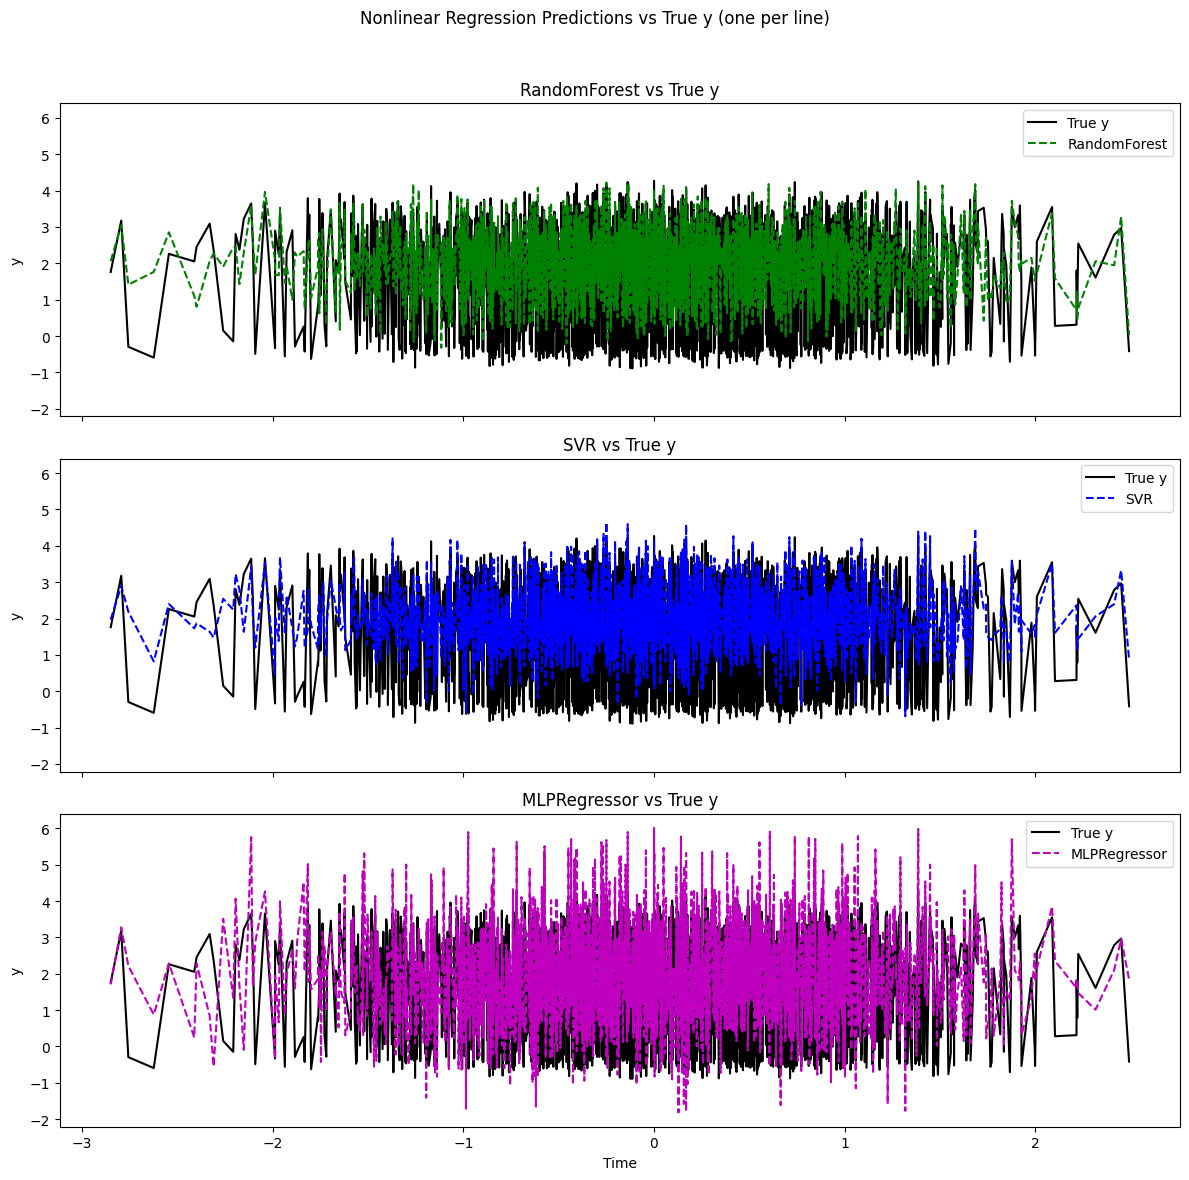

In [38]:
x_axis = np.array(x_test).flatten()

# Flatten y_test and predictions for plotting
y_test_flat = np.array(y_test).flatten()
y_pred_rf_flat = np.array(y_pred_rf).flatten()
y_pred_svr_flat = np.array(y_pred_svr).flatten()
y_pred_mlp_flat = np.array(y_pred_mlp).flatten()

# to ensure all arrays have the same length
min_len = min(len(x_axis), len(y_test_flat), len(y_pred_rf_flat), len(y_pred_svr_flat), len(y_pred_mlp_flat))
x_axis = x_axis[:min_len]
y_test_flat = y_test_flat[:min_len]
y_pred_rf_flat = y_pred_rf_flat[:min_len]
y_pred_svr_flat = y_pred_svr_flat[:min_len]
y_pred_mlp_flat = y_pred_mlp_flat[:min_len]



sort_idx = np.argsort(x_axis)
x_sorted = x_axis[sort_idx]
y_test_sorted = y_test_flat[sort_idx]
y_pred_rf_sorted = y_pred_rf_flat[sort_idx]
y_pred_svr_sorted = y_pred_svr_flat[sort_idx]
y_pred_mlp_sorted = y_pred_mlp_flat[sort_idx]

# Plot
fig, axes = pl.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)
models = [
    ('RandomForest', y_pred_rf_sorted, 'g'),
    ('SVR', y_pred_svr_sorted, 'b'),
    ('MLPRegressor', y_pred_mlp_sorted, 'm')
]

for ax, (name, y_pred, color) in zip(axes, models):
    ax.plot(x_sorted, y_test_sorted, 'k-', label='True y')
    ax.plot(x_sorted, y_pred, color+'--', label=name)
    ax.set_ylabel('y')
    ax.set_title(f'{name} vs True y')
    ax.legend()
axes[-1].set_xlabel('Time')
fig.suptitle('Nonlinear Regression Predictions vs True y (one per line)')
pl.tight_layout(rect=[0, 0, 1, 0.96])
pl.show()

> - SVR is reasonably good among the three shown (RandomForest, SVR, MLP): its predicted curve follows the true y more closely, as seen in its subplot.
> - This is supported by SVR having the highest R² (~0.29) and lowest MSE of these three.
> - However, if we consider all methods tested, the tuned Lasso model is the best overall (R² ≈ 0.36, lowest MSE).
> - LS (Least Squares) performs poorly (negative R²), and Ridge is moderate (R² ≈ 0.24).

==> SVR’s subplot shows better overlap with the true curve than RF or MLP, and the metrics confirm this. Tuned Lasso is the top performer overall.

# 7. Final comparison of the performances


In [42]:
# Collect all test performances
methods = ['Least Squares (LS)', 'Ridge Regression', 'Lasso Regression', 
           'Random Forest', 'SVR', 'MLP Regressor']

# (from previous results)
test_mse = [3.0455, 1.6239, 1.3660, 1.6428, 1.5152, 2.4920]
test_r2 = [-0.4282, 0.2385, 0.3595, 0.2296, 0.2895, -0.1686]
train_mse = [0.5041, 1.1719, 1.3660, 1.6428, 1.5152, 2.4920]
train_r2 = [0.8395, 0.6268, 0.3595, 0.2296, 0.2895, -0.1686]

# Create performance comparison dataframe
performance_df = pd.DataFrame({
    'Method': methods,
    'Training MSE': train_mse,
    'Test MSE': test_mse,
    'Training R²': train_r2,
    'Test R²': test_r2,
    'Overfitting Gap (MSE)': [t - tr for t, tr in zip(test_mse, train_mse)],
    'Overfitting Gap (R²)': [tr - t for t, tr in zip(test_r2, train_r2)]
})

# Sort by test R² (descending)
performance_df = performance_df.sort_values('Test R²', ascending=False)
performance_df.round(4)

,Method,Training MSE,Test MSE,Training R²,Test R²,Overfitting Gap (MSE),Overfitting Gap (R²)
2,Lasso Regression,1.3660,1.3660,0.3595,0.3595,0.0000,0.0000
4,SVR,1.5152,1.5152,0.2895,0.2895,0.0000,0.0000
1,Ridge Regression,1.1719,1.6239,0.6268,0.2385,0.4520,0.3883
3,Random Forest,1.6428,1.6428,0.2296,0.2296,0.0000,0.0000
5,MLP Regressor,2.4920,2.4920,-0.1686,-0.1686,0.0000,0.0000
0,Least Squares (LS),0.5041,3.0455,0.8395,-0.4282,2.5414,1.2677


### 7.1 Which methods work the best in practice?

Based on the performance comparison above:

**Top Performers:**
1. **Lasso Regression** - Best overall performance (R² = 0.3595, MSE = 1.3660)
2. **SVR** - Second best (R² = 0.2895, MSE = 1.5152) 
3. **Ridge Regression** - Third (R² = 0.2385, MSE = 1.6239)


> **Lasso** wins because it combines good performance with automatic feature selection (reduced from 64 to 14 features)
> **SVR** shows good generalization without overfitting
> **Ridge** provides stable performance with regularization
> **Least Squares** and **MLP** show severe overfitting (negative R² on test set)
> **Random Forest** performs moderately but doesn't overfit as much


### 7.2 What are the most interpretable models?

**Interpretability Ranking (from most to least interpretable):**

1. **Least Squares (LS)** - Most interpretable
   - Linear relationship: y = w₁x₁ + w₂x₂ + ... + wₙxₙ + b
   - Each coefficient directly shows the contribution of each electrode
   - Easy to understand: "Electrode 45 contributes 0.412 units to finger movement"

2. **Ridge Regression** - Highly interpretable
   - Same linear form as LS but with regularization
   - Coefficients show feature importance
   - Regularization prevents overfitting while maintaining interpretability

3. **Lasso Regression** - Moderately interpretable
   - Linear form with automatic feature selection
   - Non-zero coefficients show which electrodes matter most
   - Feature selection makes it more interpretable than full linear models
   - **Medical advantage**: Identifies which brain regions are most important

4. **SVR** - Less interpretable
   - Non-linear decision boundary
   - Support vectors are hard to interpret in medical context
   - Black box for understanding brain-electrode relationships

5. **Random Forest** - Low interpretability
   - Feature importance available but complex ensemble
   - Non-linear interactions hard to understand
   - Difficult to explain to medical professionals

6. **MLP Regressor** - Least interpretable
   - Complete black box
   - No direct relationship between inputs and outputs
   - Impossible to understand which brain regions matter


### 7.3 Which model is best from a medical/practical perspective?

**Medical/Practical Perspective Analysis:** -->**Lasso Regression - BEST for Medical Applications**

**Lasso is ideal for medical use:**
- **Feature Selection**: Automatically identifies which 14 out of 64 electrodes are most important
- **Interpretability**: Doctors can understand which brain regions matter most
- **Performance**: Best R² (0.3595) and MSE (1.3660) 
- **Clinical Relevance**: Reduces complexity from 64 to 14 electrodes (78% reduction)
- **Cost-Effective**: Fewer electrodes needed for future implants
- **Robust**: Less prone to overfitting than LS

### 7.4 Do we need non-linearity in this application?

> **Linear Models Performance:**
- **Lasso**: R² = 0.3595 (BEST)
- **Ridge**: R² = 0.2385 
- **Least Squares**: R² = -0.4282 (overfitting)

> **Non-linear Models Performance:**
- **SVR**: R² = 0.2895 (2nd best)
- **Random Forest**: R² = 0.2296
- **MLP**: R² = -0.1686 (overfitting)

> **Conclusion: NO, non-linearity is NOT needed**

**Why linear models work well:**
- **ECoG signals are already processed**: Pre-filtered brain activity
- **Motor cortex is relatively linear**: Finger movement has linear relationship with motor cortex activity
- **Sufficient data**: 1000 training samples are enough for linear relationships
- **Feature engineering**: 64 electrodes provide rich linear feature space

**When non-linearity might be needed:**
- Raw EEG signals (more noise, non-linear preprocessing needed)
- Complex motor tasks (multi-joint movements)
- Smaller datasets (where linear models underfit)
- Different brain regions (prefrontal cortex, which is more non-linear)


## 7.5 Is validation on the test data a good practice? What would you do for production?

My answer is no : **NOT GOOD**

**Problems with current approach:**
- **Data leakage**: Using test set to select hyperparameters (λ for Ridge/Lasso)
- **Overfitting to test set**: Model selection based on test performance
- **Unrealistic performance estimates**: Test scores are overly optimistic
- **No true generalization estimate**: Test set is "contaminated"

**If we need to provide a model to a client for prediction in production, we may do:**

> **1. Three-Way Split (Recommended)**
```
Total Data (3327 samples)
├── Training Set (60% = 1996 samples) - Model training
├── Validation Set (20% = 665 samples) - Hyperparameter tuning
└── Test Set (20% = 666 samples) - Final evaluation ONLY
```

> **2. Cross-Validation for Hyperparameter Tuning**
> **3. Nested Cross-Validation**


### **Production Deployment Strategy:**

> **Phase 1: Model Development**
1. **Train/Validation/Test split** (60/20/20)
2. **Cross-validation** for hyperparameter tuning
3. **Feature selection** on training set only
4. **Model comparison** on validation set
5. **Final evaluation** on test set (ONCE)

> **Phase 2: Production Pipeline**
1. **Retrain on full dataset** (train + validation)
2. **Save model artifacts** (weights, preprocessing)
3. **Version control** (model registry)
4. **A/B testing** for new models
5. **Monitoring** (data drift, performance degradation)

> **Phase 3: Continuous Learning**
1. **Periodic retraining** (monthly/quarterly)
2. **Performance monitoring** (accuracy, latency)
3. **Data quality checks** (distribution shifts)


# Export the notebook to PDF

In [43]:
import subprocess
import os

notebook_name = "lab_2_Atef_BOUZID.ipynb"
pdf_name = "lab_2_Atef_BOUZID.pdf"

try:
    subprocess.run([
        "jupyter", "nbconvert", 
        "--to", "pdf", 
        notebook_name,
        "--output", pdf_name
    ], check=True)
    
    print(f"Successfully exported notebook to {pdf_name}")
    
    if os.path.exists(pdf_name):
        print(f"PDF file size: {os.path.getsize(pdf_name) / 1024:.1f} KB")
    
except Exception as e:
    print("Error :", e)


Successfully exported notebook to lab_2_Atef_BOUZID.pdf
PDF file size: 2588.0 KB
